In [2]:
# 1 번 셀 --------------------------------
# import shutil
# import glob
# from torchvision.transforms import ToTensor
# import torchvision.models as models
# from tqdm import tqdm
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from torchsummary import summary

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import random
from PIL import Image
from tqdm.notebook import tqdm_notebook


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [3]:
# 2 번 셀 --------------------------------
class ImageTransform:
    def __init__(self, resize, mean, std):
        self.data_transform = {
            "train": transforms.Compose(
                [
                    transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std),
                ]
            ),
            "val": transforms.Compose(
                [
                    transforms.Resize(256),
                    transforms.CenterCrop(resize),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std),
                ]
            ),
        }

    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [4]:
# 3 번 셀 --------------------------------
cat_directory = r"C:\chungnam_chatbot\pytorch\data\dogs-vs-cats\Cat"
dog_directory = r"C:\chungnam_chatbot\pytorch\data\dogs-vs-cats\Dog"

cat_images_filepaths = sorted(
    [os.path.join(cat_directory, f) for f in os.listdir(cat_directory)]
)
dog_images_filepaths = sorted(
    [os.path.join(dog_directory, f) for f in os.listdir(dog_directory)]
)

# [[], []] -> [....]
# cat_images_filepaths.extend(dog_images_filepaths)
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]

# 에러 처리.
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_image_filepaths = correct_images_filepaths[:400]
val_image_filepaths = correct_images_filepaths[400:-10]
test_image_filepaths = correct_images_filepaths[-10:]
print(len(train_image_filepaths), len(val_image_filepaths), len(test_image_filepaths))

400 92 10


In [5]:
# 5 번 셀 --------------------------------
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, tranform=None, phase="train") -> None:
        super().__init__()
        self.file_list = file_list
        self.transform = tranform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        # aa
        label = img_path.split("\\")[-1].split(".")[0]
        if label == "dog":
            label = 1
        elif label == "cat":
            label = 0
        return img_transformed, label

In [6]:
# 6 번 셀 --------------------------------
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

train_dataset = DogvsCatDataset(
    train_image_filepaths, tranform=ImageTransform(size, mean, std), phase="train"
)

val_dataset = DogvsCatDataset(
    val_image_filepaths, tranform=ImageTransform(size, mean, std), phase="val"
)
test_dataset = DogvsCatDataset(
    val_image_filepaths, tranform=ImageTransform(size, mean, std), phase="val"
)
index = 0
# print(train_dataset.__getitem__(index)[0].size())
# print(train_dataset.__getitem__(index)[1])
print(train_dataset[index][0].size())
print(train_dataset[index][1])


torch.Size([3, 256, 256])
0


In [7]:
# 7 번 셀 --------------------------------
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {"train": train_dataloader, "val": val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 256, 256])
tensor([0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 1, 0, 1, 0, 0])


In [8]:
class AlexNet(nn.Module):
    def __init__(self) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [9]:
model = AlexNet()
model.to(device)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
# 12 번 셀 ---------------------------------
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [11]:
# 10 번 셀 --------------------------------

# mat 갯수가 달라지는 애러 발생.
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

In [19]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch):
        print(f"Epoch {epoch+1} / {num_epoch}")
        print("-" * 20)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            # tqdm 실행 안됨.
            for inputs, labels in tqdm_notebook(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

            print(f"{phase} Loss: {epoch_loss} Acc: {epoch_acc}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed % 60:.0f}s")
    return model


num_epoch = 100
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6926165747642518 Acc: 0.5


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6925660242205081 Acc: 0.5108695652173912
Epoch 2 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6929742527008057 Acc: 0.515


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6925501693849978 Acc: 0.5108695652173912
Epoch 3 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.692443356513977 Acc: 0.5


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6924639188725016 Acc: 0.5108695652173912
Epoch 4 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.692944324016571 Acc: 0.5


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6923938808233842 Acc: 0.5108695652173912
Epoch 5 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6930226016044617 Acc: 0.5025000000000001


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6923633684282717 Acc: 0.5108695652173912
Epoch 6 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6929840898513794 Acc: 0.5075000000000001


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6923381271569625 Acc: 0.5108695652173912
Epoch 7 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6927988266944886 Acc: 0.51


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6923579495886097 Acc: 0.5108695652173912
Epoch 8 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6926978302001953 Acc: 0.5075000000000001


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6922369288361591 Acc: 0.5108695652173912
Epoch 9 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6924519252777099 Acc: 0.505


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6921838625617649 Acc: 0.5108695652173912
Epoch 10 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.692924394607544 Acc: 0.5


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6921748648519102 Acc: 0.5108695652173912
Epoch 11 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6920774507522583 Acc: 0.5


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6921320583509363 Acc: 0.5108695652173912
Epoch 12 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6924593949317932 Acc: 0.5125


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6921670359113942 Acc: 0.5108695652173912
Epoch 13 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6921992564201355 Acc: 0.5225


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6920567388119905 Acc: 0.5108695652173912
Epoch 14 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.692317156791687 Acc: 0.4875


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6919883671014205 Acc: 0.5108695652173912
Epoch 15 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6924014949798584 Acc: 0.5125


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.691931760829428 Acc: 0.5108695652173912
Epoch 16 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6920328712463379 Acc: 0.515


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6918716016023055 Acc: 0.5108695652173912
Epoch 17 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6917081379890442 Acc: 0.5025000000000001


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6917750083881876 Acc: 0.5108695652173912
Epoch 18 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6919003129005432 Acc: 0.51


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6916703815045564 Acc: 0.5108695652173912
Epoch 19 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6919095039367675 Acc: 0.5075000000000001


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6916338879129161 Acc: 0.5108695652173912
Epoch 20 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6920892763137817 Acc: 0.51


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6916233352992845 Acc: 0.5108695652173912
Epoch 21 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6919518971443176 Acc: 0.505


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6915633808011594 Acc: 0.5108695652173912
Epoch 22 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6916508102416992 Acc: 0.485


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6915512577347134 Acc: 0.5217391304347826
Epoch 23 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.691892786026001 Acc: 0.5025000000000001


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6914697859598242 Acc: 0.5108695652173912
Epoch 24 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.691592104434967 Acc: 0.515


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6913314617198446 Acc: 0.5108695652173912
Epoch 25 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6908168458938598 Acc: 0.5125


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6912832908008409 Acc: 0.5108695652173912
Epoch 26 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6914770841598511 Acc: 0.5075000000000001


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6912463592446368 Acc: 0.5108695652173912
Epoch 27 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6907852983474732 Acc: 0.51


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6911628168562184 Acc: 0.5108695652173912
Epoch 28 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6910760068893432 Acc: 0.5175


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6910918329073035 Acc: 0.5108695652173912
Epoch 29 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6905706810951233 Acc: 0.5125


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6910790567812712 Acc: 0.5434782608695652
Epoch 30 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6911224842071533 Acc: 0.515


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6910148159317349 Acc: 0.5543478260869565
Epoch 31 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6908317923545837 Acc: 0.5325


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6909225997717484 Acc: 0.5108695652173912
Epoch 32 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6909046840667724 Acc: 0.51


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6908346466396166 Acc: 0.5108695652173912
Epoch 33 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6907182335853577 Acc: 0.505


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6907360994297526 Acc: 0.5108695652173912
Epoch 34 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6899040484428406 Acc: 0.5025000000000001


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6906599946643995 Acc: 0.5108695652173912
Epoch 35 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6900233602523804 Acc: 0.5075000000000001


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6906011907950692 Acc: 0.5108695652173912
Epoch 36 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6900371789932251 Acc: 0.5025000000000001


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6905995814696603 Acc: 0.5434782608695652
Epoch 37 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6899925756454468 Acc: 0.5


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6905348534169404 Acc: 0.5434782608695652
Epoch 38 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.689654974937439 Acc: 0.5175


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6904436894085096 Acc: 0.5543478260869565
Epoch 39 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6892559576034546 Acc: 0.5


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.690380158631698 Acc: 0.5217391304347826
Epoch 40 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6896070909500122 Acc: 0.5125


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.690306438052136 Acc: 0.5434782608695652
Epoch 41 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.68952716588974 Acc: 0.525


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6902455246966818 Acc: 0.5543478260869565
Epoch 42 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6884611225128174 Acc: 0.5075000000000001


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6902160411295684 Acc: 0.5434782608695652
Epoch 43 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6885696077346801 Acc: 0.52


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6901353701301243 Acc: 0.5543478260869565
Epoch 44 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6883201432228089 Acc: 0.525


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6901285674261011 Acc: 0.5543478260869565
Epoch 45 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6884083104133606 Acc: 0.525


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6900480700575787 Acc: 0.5543478260869565
Epoch 46 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6881082582473755 Acc: 0.54


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6899146282154581 Acc: 0.5434782608695652
Epoch 47 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6876872849464416 Acc: 0.545


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6898702046145564 Acc: 0.5543478260869565
Epoch 48 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6873814296722413 Acc: 0.5275


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6896684092024098 Acc: 0.5434782608695652
Epoch 49 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6864636373519898 Acc: 0.555


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.689580500125885 Acc: 0.5434782608695652
Epoch 50 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6865527725219727 Acc: 0.5325


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6894366767095483 Acc: 0.5434782608695652
Epoch 51 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6861761140823365 Acc: 0.5325


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6893498819807301 Acc: 0.5434782608695652
Epoch 52 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6861845636367798 Acc: 0.55


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6892307452533556 Acc: 0.5434782608695652
Epoch 53 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6858457517623902 Acc: 0.555


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.689067182333573 Acc: 0.5543478260869565
Epoch 54 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6864753031730652 Acc: 0.5575


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6888483581335648 Acc: 0.5434782608695652
Epoch 55 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.686605429649353 Acc: 0.5575


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6885847708453303 Acc: 0.5543478260869565
Epoch 56 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6849789714813233 Acc: 0.5575


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.688624892545783 Acc: 0.5434782608695652
Epoch 57 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.684083125591278 Acc: 0.5625


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6882488623909329 Acc: 0.5543478260869565
Epoch 58 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6852242779731751 Acc: 0.5575


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6880073962004288 Acc: 0.5543478260869565
Epoch 59 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6848061990737915 Acc: 0.585


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6878985036974368 Acc: 0.5543478260869565
Epoch 60 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6853691077232361 Acc: 0.5475


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6878255994423575 Acc: 0.532608695652174
Epoch 61 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6829266357421875 Acc: 0.56


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6872774232988772 Acc: 0.5543478260869565
Epoch 62 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6821622467041015 Acc: 0.5825


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6871499263721964 Acc: 0.5434782608695652
Epoch 63 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6805956721305847 Acc: 0.5875


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6865989721339681 Acc: 0.5652173913043478
Epoch 64 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6791992568969727 Acc: 0.5750000000000001


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6865108479624209 Acc: 0.5543478260869565
Epoch 65 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6793914747238159 Acc: 0.5875


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6862681819045026 Acc: 0.5543478260869565
Epoch 66 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6799267625808716 Acc: 0.5425


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6868672319080519 Acc: 0.532608695652174
Epoch 67 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6783920121192932 Acc: 0.5775


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6854829425397126 Acc: 0.5652173913043478
Epoch 68 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6794065594673157 Acc: 0.6075


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6844732191251672 Acc: 0.5869565217391304
Epoch 69 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6785412311553956 Acc: 0.58


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6839630344639653 Acc: 0.5760869565217391
Epoch 70 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6780669260025024 Acc: 0.605


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6828194571577985 Acc: 0.5869565217391304
Epoch 71 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6776780462265015 Acc: 0.605


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6822424142257028 Acc: 0.5760869565217391
Epoch 72 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6765907788276673 Acc: 0.59


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6811738169711569 Acc: 0.5760869565217391
Epoch 73 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6747162938117981 Acc: 0.6225


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6806035430535026 Acc: 0.5543478260869565
Epoch 74 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.671469988822937 Acc: 0.63


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6803023374598959 Acc: 0.5760869565217391
Epoch 75 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.670950026512146 Acc: 0.59


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6803520736487015 Acc: 0.5652173913043478
Epoch 76 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6711069393157959 Acc: 0.5925


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6781205871830815 Acc: 0.5652173913043478
Epoch 77 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6693847107887269 Acc: 0.5975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6773565489312877 Acc: 0.5652173913043478
Epoch 78 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6702349233627319 Acc: 0.6225


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6738353838091311 Acc: 0.5869565217391304
Epoch 79 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6656240534782409 Acc: 0.67


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.672404856785484 Acc: 0.5760869565217391
Epoch 80 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.66692636013031 Acc: 0.6325000000000001


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6711137346599413 Acc: 0.5543478260869565
Epoch 81 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6646166324615479 Acc: 0.6475


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6701575854550237 Acc: 0.5978260869565217
Epoch 82 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6600056838989258 Acc: 0.655


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6716528146163278 Acc: 0.5760869565217391
Epoch 83 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6620766711235047 Acc: 0.62


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6701314993526625 Acc: 0.5760869565217391
Epoch 84 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6593219804763794 Acc: 0.6325000000000001


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.668270222518755 Acc: 0.5760869565217391
Epoch 85 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6563450908660888 Acc: 0.64


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6636040081148562 Acc: 0.5978260869565217
Epoch 86 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6554389691352844 Acc: 0.635


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.665635549503824 Acc: 0.5869565217391304
Epoch 87 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.652046377658844 Acc: 0.645


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.661535804686339 Acc: 0.6739130434782609
Epoch 88 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6528913354873658 Acc: 0.6375000000000001


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6575203071469846 Acc: 0.6086956521739131
Epoch 89 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6482682681083679 Acc: 0.65


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6574973774992902 Acc: 0.6086956521739131
Epoch 90 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6521746730804443 Acc: 0.66


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6528187653292781 Acc: 0.6304347826086957
Epoch 91 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.651228768825531 Acc: 0.65


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6522189922954725 Acc: 0.5978260869565217
Epoch 92 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6447603559494018 Acc: 0.6625


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6584879470908124 Acc: 0.6739130434782609
Epoch 93 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6478470540046692 Acc: 0.6575


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.652285837608835 Acc: 0.6195652173913043
Epoch 94 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6477430391311646 Acc: 0.65


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6502569576968318 Acc: 0.6739130434782609
Epoch 95 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6474376678466797 Acc: 0.6475


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6528554921564849 Acc: 0.6086956521739131
Epoch 96 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6399895191192627 Acc: 0.6475


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6623438778130905 Acc: 0.5978260869565217
Epoch 97 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.672140543460846 Acc: 0.5775


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6838943180830582 Acc: 0.5434782608695652
Epoch 98 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6474889492988587 Acc: 0.645


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6502130809037582 Acc: 0.6739130434782609
Epoch 99 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6411585021018982 Acc: 0.645


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.651197586370551 Acc: 0.6195652173913043
Epoch 100 / 100
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6349378991127014 Acc: 0.6575


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6450354871542557 Acc: 0.6739130434782609
Training complete in 4m 39s


In [16]:
id_list = []
pred_list = []
_id = 0

with torch.no_grad():
    for test_path in tqdm_notebook(test_image_filepaths):
        img = Image.open(test_path)
        _id = test_path.split("\\")[-1].split(".")[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase="val")
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        id_list.append(_id)
        pred_list.append(preds[0])

res = pd.DataFrame({"id": id_list, "label": pred_list})
res.head(10)

  0%|          | 0/10 [00:00<?, ?it/s]

id     label
0  145  0.503866
1  211  0.503998
2  162  0.503501
3  200  0.505529
4  210  0.504324
5  224  0.503716
6  213  0.503263
7  109  0.505226
8   15  0.503938
9  167  0.502891

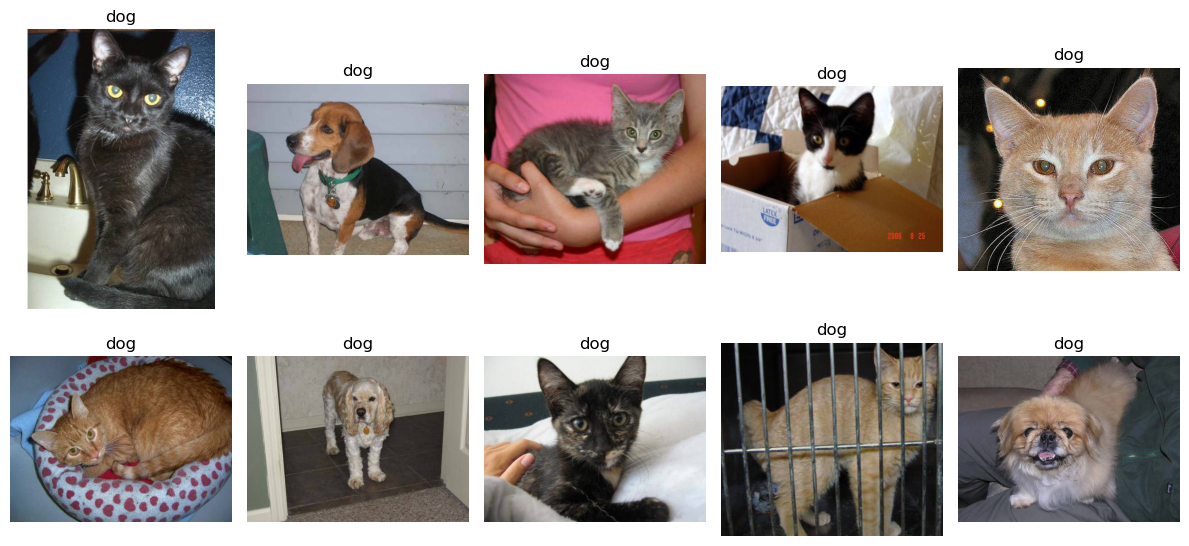

In [18]:
class_ = Classes = {0: "cat", 1: "dog"}
def display_image_grid2(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        a = random.choice(res["id"].values)
        label = res.loc[res["id"] == a, "label"].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()


display_image_grid2(test_image_filepaths)